In [1]:
! pip install torch==2.9.0 transformers==4.57.3 matplotlib==3.10.0 pandas==2.2.2 numpy==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.0
    Uninstalling huggingface_hub-1.4.0:
      Successfully uninstalled huggingface_hub-1.4.0
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=dtype, # Data type for model weights
    trust_remote_code=True # Allow custom code from repo
).to(device) # Move model to device

model.eval() # Evaluation Mode
# Dropout is disabled (no random dropping of neurons).
# BatchNorm uses running statistics instead of batch statistics.

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [9]:
# Qwen configs sometimes have no pad_token set; safest is EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

print("Loaded Tokenixer:", tokenizer.name_or_path)
print("Loaded Model:", model.name_or_path)
print("Device:", device, "| dtype:", dtype )

Loaded Tokenixer: Qwen/Qwen2.5-0.5B
Loaded Model: Qwen/Qwen2.5-0.5B
Device: cpu | dtype: torch.float32


In [10]:
def pretty_token(t: str) -> str:
    # Byte-level BPE style space/newline markers
    t = t.replace("Ġ", " ")
    t = t.replace("Ċ", "\\n")
    return t

def get_next_token_topk(prompt, top_k=10):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1]
    probs = F.softmax(logits, dim=-1)

    top_probs, top_ids = torch.topk(probs, top_k)
    tokens = tokenizer.convert_ids_to_tokens(top_ids.tolist())
    pretty = [pretty_token(t) for t in tokens]

    return pretty, top_probs.detach().cpu().tolist()


# Plot helper
def plot_topk(tokens_a, probs_a, tokens_b, probs_b, title_a, title_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    axes[0].bar(range(len(tokens_a)), probs_a)
    axes[0].set_xticks(range(len(tokens_a)))
    axes[0].set_xticklabels(tokens_a, rotation=60, ha="right")
    axes[0].set_title(title_a)
    axes[0].set_ylabel("Probability")

    axes[1].bar(range(len(tokens_b)), probs_b)
    axes[1].set_xticks(range(len(tokens_b)))
    axes[1].set_xticklabels(tokens_b, rotation=60, ha="right")
    axes[1].set_title(title_b)

    plt.show()


Prompt A: The capital of France is
             Paris  0.3156
            ______  0.1146
              ____  0.0635
                __  0.0551
               :\n  0.0513
           located  0.0359
               the  0.0280
                \n  0.0246
                 (  0.0197
               .\n  0.0188

Prompt B: The capital of Germany is
            Berlin  0.1676
                __  0.1174
            ______  0.0960
              ____  0.0557
           located  0.0444
               the  0.0421
               :\n  0.0309
           Hamburg  0.0287
                \n  0.0270
                 (  0.0264


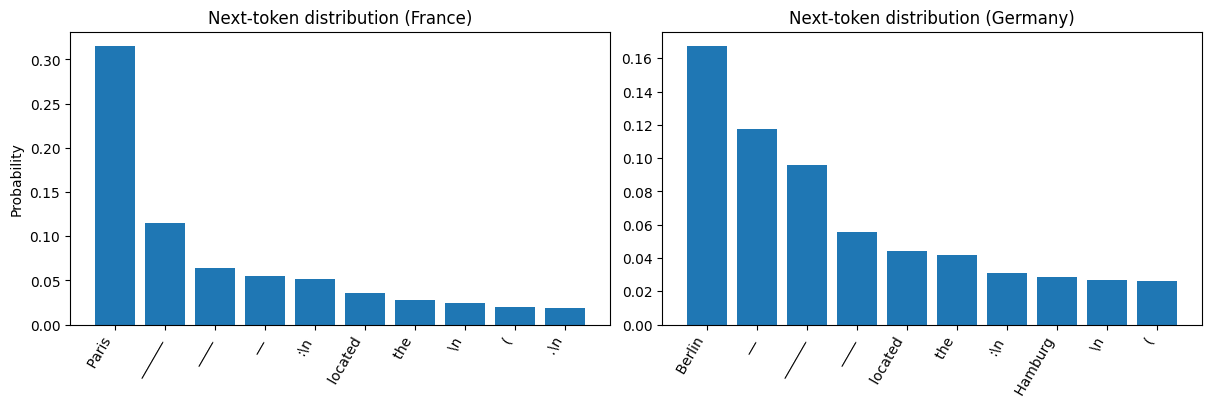

In [11]:
# Prompts differ by ONE token
prompt_a = "The capital of France is"
prompt_b = "The capital of Germany is"

top_k = 10
tokens_a, probs_a = get_next_token_topk(prompt_a, top_k=top_k)
tokens_b, probs_b = get_next_token_topk(prompt_b, top_k=top_k)

print("\nPrompt A:", prompt_a)
for t, p in zip(tokens_a, probs_a):
    print(f"{t:>18}  {p:.4f}")

print("\nPrompt B:", prompt_b)
for t, p in zip(tokens_b, probs_b):
    print(f"{t:>18}  {p:.4f}")

plot_topk(
    tokens_a, probs_a,
    tokens_b, probs_b,
    title_a="Next-token distribution (France)",
    title_b="Next-token distribution (Germany)"
)